### `Vie Dataset for RSVP`

In [1]:
csvList = [
    "C:/Users/ryoii/OneDrive/Documents/GitHub/P300Speller_2_electrodes/Experiment/data/RSVP/ryo_RSVP_20250701T194820_data.csv",
    "C:/Users/ryoii/OneDrive/Documents/GitHub/P300Speller_2_electrodes/Experiment/data/RSVP/ryo_RSVP_20250701T200442_data.csv",
    "C:/Users/ryoii/OneDrive/Documents/GitHub/P300Speller_2_electrodes/Experiment/data/RSVP/ryo_RSVP_20250701T201326_data.csv",
    "C:/Users/ryoii/OneDrive/Documents/GitHub/P300Speller_2_electrodes/Experiment/data/RSVP/ryo_RSVP_20250701T203009_data.csv"
]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, re
import joblib
from scipy.signal import butter, filtfilt
import statsmodels.api as sm 
from sklearn.linear_model import LinearRegression 

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001C48C128F70>>
Traceback (most recent call last):
  File "c:\Users\ryoii\OneDrive\Documents\GitHub\P300Speller_2_electrodes\p300env\lib\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
# Filtering functions
def butter_lowpass_filter(data, lowcut, fs, order):
    """Applies a Butterworth low-pass filter."""
    nyq = fs/2
    low = lowcut/nyq
    b, a = butter(order, low, btype='low')
    y = filtfilt(b, a, data) # zero-phase filter # data: [ch x time]
    return y

def butter_highpass_filter(data, highcut, fs, order):
    """Applies a Butterworth high-pass filter."""
    nyq = fs/2
    high = highcut/nyq
    b, a = butter(order, high, btype='high')
    y = filtfilt(b, a, data) # zero-phase filter
    return y

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    """Applies a Butterworth band-pass filter."""
    nyq = fs/2
    low = lowcut/nyq
    high = highcut/nyq
    b, a = butter(order, [low, high], btype='band')
    # demean before filtering to remove DC offset
    meandat = np.mean(data, axis=1, keepdims=True) # Keepdims for broadcasting
    data = data - meandat
    y = filtfilt(b, a, data)
    return y

In [4]:
"""
extractEpoch3D: extract and baseline-correct time-locked epochs from continuous EEG data
baseline (used for correction and normalization): [-200, 0] ms relative to event
frame: [-200, 1000] ms relative to event (defines the epoch window for plotting)
"""
def extractEpoch3D(data, event_samples, srate, baseline_ms, frame_ms, opt_keep_baseline):
    """
    Extracts and baseline-corrects time-locked epochs from 2D continuous EEG data
    into a 3D array [channels x time x trials].

    Args:
        data (np.array): Continuous EEG data, shape [channels x time_points].
        event_samples (np.array): 1D array of event timestamps in samples.
        srate (float): Sampling rate in Hz.
        baseline_ms (list): [start_ms, end_ms] for baseline correction (e.g., [-200, 0]).
        frame_ms (list): [start_ms, end_ms] for epoch extraction (e.g., [-200, 1000]).
        opt_keep_baseline (bool): If True, the extracted epoch includes the baseline period.
                                  If False, the epoch starts at frame_ms[0].

    Returns:
        np.array: 3D array of epoched data [channels x time_points_in_epoch x trials].
    """
    # Calculate epoch start and end points in samples based on frame_ms
    # This determines the size of each epoch.
    if opt_keep_baseline:
        # If keeping baseline, the epoch starts at baseline_ms[0]
        begin_epoch_sample_offset = int(np.floor(baseline_ms[0] / 1000 * srate))
        end_epoch_sample_offset = int(np.floor(frame_ms[1] / 1000 * srate))
        epoch_length_samples = end_epoch_sample_offset - begin_epoch_sample_offset
    else:
        # If not keeping baseline, the epoch starts at frame_ms[0]
        begin_epoch_sample_offset = int(np.floor(frame_ms[0] / 1000 * srate))
        end_epoch_sample_offset = int(np.floor(frame_ms[1] / 1000 * srate))
        epoch_length_samples = end_epoch_sample_offset - begin_epoch_sample_offset
    
    # Ensure epoch_length_samples is at least 1
    if epoch_length_samples <= 0:
        print("Error: Calculated epoch length is zero or negative. Check frame_ms and srate.")
        return np.array([]) # Return empty array if length is invalid

    # Pre-allocate memory for the 3D epoch array
    # Initialize with zeros, but if no events are found, it will be resized later
    epoch3D = np.zeros((data.shape[0], epoch_length_samples, len(event_samples)))
    
    nth_event = 0 # Counter for successfully extracted epochs

    for i_event_sample in event_samples:
        # Calculate the actual start and end sample indices for the epoch
        # relative to the continuous data, centered around i_event_sample.
        epoch_start_idx = int(i_event_sample + begin_epoch_sample_offset)
        epoch_end_idx = int(i_event_sample + end_epoch_sample_offset)
        
        # Check if the epoch range is within the bounds of the continuous data
        if epoch_start_idx < 0 or epoch_end_idx > data.shape[1]:
            # print(f"Warning: Event at sample {i_event_sample} results in out-of-bounds epoch ({epoch_start_idx}:{epoch_end_idx}). Skipping.")
            continue # Skip this event if it's out of bounds

        # Extract the temporary epoch data
        tmp_epoch_data = data[:, epoch_start_idx:epoch_end_idx]

        # Calculate baseline indices from the *original* continuous data
        # The baseline period is always relative to the event sample (i_event_sample)
        base_start_idx_orig = int(i_event_sample + np.floor(baseline_ms[0] / 1000 * srate))
        base_end_idx_orig = int(i_event_sample + np.floor(baseline_ms[1] / 1000 * srate))

        # Check if baseline range is within the bounds of the continuous data
        if base_start_idx_orig < 0 or base_end_idx_orig >= data.shape[1] or (base_end_idx_orig - base_start_idx_orig) <= 0:
            # print(f"Warning: Baseline for event at sample {i_event_sample} results in out-of-bounds ({base_start_idx_orig}:{base_end_idx_orig}) or zero length. Skipping.")
            continue # Skip this event if its baseline is out of bounds or has no length

        # Compute the mean of the baseline period for each channel
        baseline_mean = np.mean(data[:, base_start_idx_orig:base_end_idx_orig], axis=1, keepdims=True)

        # Apply baseline correction: subtract the mean baseline from the extracted epoch
        rmbase_data = tmp_epoch_data - baseline_mean

        # Final check on the shape of the extracted epoch before storing
        if rmbase_data.shape[1] != epoch_length_samples:
            # This should ideally not happen if calculations are correct and within bounds
            # print(f"Warning: Extracted epoch for event {i_event_sample} has unexpected time points {rmbase_data.shape[1]}, expected {epoch_length_samples}. Skipping.")
            continue

        # Store the baseline-corrected epoch in the 3D array
        epoch3D[:, :, nth_event] = rmbase_data
        nth_event += 1

    # If some events were skipped, resize the pre-allocated array to actual number of epochs
    if nth_event < len(event_samples):
        epoch3D = epoch3D[:, :, :nth_event]
        if nth_event == 0: # If no valid epochs were extracted
            print(f"Note: No valid epochs extracted from {len(event_samples)} potential events.")
            return np.array([]) # Return empty array if no epochs
        else:
            print(f"Note: {len(event_samples) - nth_event} events were skipped due to out-of-bounds issues during epoch or baseline extraction.")
    
    return epoch3D

In [5]:
def load_eeg_from_csv(csv_file_path, srate, eeg_cols, marker_col, trial_rows_per_segment=1980, eeg_samples_per_trial_epoch=1320):
    """
    Loads EEG data and generates markers from a CSV file with specific trial structure.

    Args:
        csv_file_path (str): Path to the CSV file.
        srate (int/float): Sampling rate of the EEG data in Hz.
        eeg_cols (list): List of column names for EEG channels (e.g., ['LEFT', 'RIGHT', 'DIFF']).
        marker_col (str): Column name for event markers (e.g., 'TrialLabel').
        trial_rows_per_segment (int): Total number of rows in CSV per trial segment (e.g., 1980).
        eeg_samples_per_trial_epoch (int): Number of EEG samples relevant for the recording epoch (e.g., 1320).

    Returns:
        dict: A dictionary containing 'data' (np.array, channels x time),
              'srate' (float), and 'markers_target' (np.array, 1D).
              Returns None if loading fails.
    """
    try:
        df = pd.read_csv(csv_file_path)
        
        # Identify rows where TrialLabel is present (start of each trial segment)
        # Use .notna() for general non-empty check, or specific string check if needed
        trial_start_row_indices = df[df[marker_col].notna() & (df[marker_col] != '')].index.tolist()
        
        if not trial_start_row_indices:
            print(f"Warning: No trial start markers found in {csv_file_path}. Returning empty data.")
            return {
                'data': np.array([]).reshape(len(eeg_cols), 0),
                'srate': srate,
                'markers_target': np.array([])
            }

        combined_eeg_data_list = []
        combined_markers_list = []
        
        total_data_length = 0 # To keep track of total samples for the continuous marker array

        # Experiment details for marker generation
        pre_stream_ms = 200
        char_duration_ms = 100
        num_characters_in_stream = 21
        
        # Calculate sample offsets
        pre_stream_samples = int(pre_stream_ms / 1000 * srate)
        char_duration_samples = int(char_duration_ms / 1000 * srate)

        for trial_num, start_row_idx in enumerate(trial_start_row_indices):
            # Define the end of the EEG recording epoch within this trial segment
            eeg_segment_end_idx = start_row_idx + eeg_samples_per_trial_epoch
            
            # Ensure we don't go out of bounds of the DataFrame
            if eeg_segment_end_idx > len(df):
                print(f"Warning: Trial {trial_num+1} starting at row {start_row_idx} would exceed CSV length. Truncating or skipping.")
                eeg_segment_end_idx = len(df)
                # If the segment is too short, it might cause issues later, consider skipping
                if (eeg_segment_end_idx - start_row_idx) < eeg_samples_per_trial_epoch:
                    print(f"Warning: Trial {trial_num+1} segment too short ({eeg_segment_end_idx - start_row_idx} samples). Skipping.")
                    continue

            # Extract EEG data for the 2.2s epoch (1320 samples)
            eeg_segment = df[eeg_cols].iloc[start_row_idx : eeg_segment_end_idx].values.T
            combined_eeg_data_list.append(eeg_segment)
            
            # Create markers for this specific trial's EEG segment
            trial_markers = np.zeros(eeg_segment.shape[1], dtype=int) # Markers for this 2.2s segment

            # Parse TrialLabel
            trial_label = str(df[marker_col].iloc[start_row_idx])
            match = re.search(r'Target_([A-Z])_Response_([A-Z])_n_(\d+)', trial_label)
            
            is_correct_trial = False
            target_order = -1 # 1-indexed order of target character in stream (1 to 21)

            if match:
                target_char = match.group(1)
                response_char = match.group(2)
                target_order = int(match.group(3))
                is_correct_trial = (target_char == response_char)
            else:
                print(f"Warning: Could not parse TrialLabel '{trial_label}' for trial {trial_num+1}. Skipping marker generation for this trial.")
                # Append zeros for markers if parsing failed, or handle as needed
                combined_markers_list.append(trial_markers)
                total_data_length += eeg_segment.shape[1]
                continue

            # Generate character presentation markers within this trial's EEG segment
            # Stream starts after pre_stream_ms (200ms)
            for char_idx in range(num_characters_in_stream): # 0 to 20
                char_onset_ms_relative_to_trial_start = pre_stream_ms + char_idx * char_duration_ms
                char_onset_sample_in_trial = int(char_onset_ms_relative_to_trial_start / 1000 * srate)

                if 0 <= char_onset_sample_in_trial < eeg_segment.shape[1]:
                    if (char_idx + 1) == target_order:
                        # This is the target character presentation
                        if is_correct_trial:
                            trial_markers[char_onset_sample_in_trial] = 1 # Correct Target
                        # If not correct, it remains 0 (dropped as per instruction)
                    else:
                        # This is a non-target character presentation
                        trial_markers[char_onset_sample_in_trial] = 2 # Non-Target
            
            combined_markers_list.append(trial_markers)
            total_data_length += eeg_segment.shape[1]

        if not combined_eeg_data_list:
            print(f"No valid EEG data segments extracted from {csv_file_path}.")
            return {
                'data': np.array([]).reshape(len(eeg_cols), 0),
                'srate': srate,
                'markers_target': np.array([])
            }

        # Concatenate all EEG segments and markers for this CSV file
        full_eeg_data = np.hstack(combined_eeg_data_list)
        full_markers_target = np.hstack(combined_markers_list)

        return {
            'data': full_eeg_data,
            'srate': srate,
            'markers_target': full_markers_target
        }

    except FileNotFoundError:
        print(f"Error: CSV file not found at {csv_file_path}")
        return None
    except KeyError as e:
        print(f"Error: Column not found in CSV: {e}. Please check 'eeg_cols' and 'marker_col'.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while loading CSV: {e}")
        return None

In [ ]:
# Vie Dataset
csvList = [
    "C:/Users/ryoii/OneDrive/Documents/GitHub/P300Speller_2_electrodes/Experiment/data/RSVP/ryo_RSVP_20250701T194820_data.csv",
    "C:/Users/ryoii/OneDrive/Documents/GitHub/P300Speller_2_electrodes/Experiment/data/RSVP/ryo_RSVP_20250701T200442_data.csv",
    "C:/Users/ryoii/OneDrive/Documents/GitHub/P300Speller_2_electrodes/Experiment/data/RSVP/ryo_RSVP_20250701T201326_data.csv",
    "C:/Users/ryoii/OneDrive/Documents/GitHub/P300Speller_2_electrodes/Experiment/data/RSVP/ryo_RSVP_20250701T203009_data.csv"
]

# Shuffle the csvList to randomize the order of sessions for training/testing split
np.random.shuffle(csvList)

# Define the columns in your CSV that contain EEG data and markers
eeg_channel_columns = ['LEFT', 'RIGHT', 'DIFF'] # Your EEG channels
marker_column = 'TrialLabel'                   # Your marker column
sampling_rate = 600                            # Your actual sampling rate in Hz

# Experiment specific constants
# Each trial segment in CSV is 1980 rows, but only 1320 samples are EEG epoch
TRIAL_ROWS_PER_CSV_SEGMENT = 1980
EEG_SAMPLES_PER_TRIAL_EPOCH = 1320 # 2.2 seconds * 600 Hz

# --- Parameters for preprocessing ---
baseline = [-200, 0] # in ms (e.g., -200ms to 0ms relative to event)
frame = [-200, 1000] # in ms (e.g., -200ms to 1000ms relative to event for epoch window)


# --- Load EEG data from CSVs and apply preprocessing ---
# Initialize EEG dictionary structure to hold data from all CSVs
EEG_csv = {
    'train': [],
    'test': []
}

# Split csvList into training and testing sets
# For demonstration, using the first 3 CSVs for training and the last 1 for testing
train_csv_files = csvList[:-1] # All but the last one
test_csv_files = csvList[-1:]  # Only the last one

print("--- Loading and processing training data from CSV files ---")
for i, csv_file_path in enumerate(train_csv_files):
    print(f"Loading training session {i+1} from: {csv_file_path}")
    session_data = load_eeg_from_csv(csv_file_path, sampling_rate, eeg_channel_columns, marker_column,
                                     trial_rows_per_segment=TRIAL_ROWS_PER_CSV_SEGMENT,
                                     eeg_samples_per_trial_epoch=EEG_SAMPLES_PER_TRIAL_EPOCH)
    if session_data:
        EEG_csv['train'].append(session_data) # Add to training data

print("\n--- Loading and processing test data from CSV files ---")
for i, csv_file_path in enumerate(test_csv_files):
    print(f"Loading test session {i+1} from: {csv_file_path}")
    session_data = load_eeg_from_csv(csv_file_path, sampling_rate, eeg_channel_columns, marker_column,
                                     trial_rows_per_segment=TRIAL_ROWS_PER_CSV_SEGMENT,
                                     eeg_samples_per_trial_epoch=EEG_SAMPLES_PER_TRIAL_EPOCH)
    if session_data:
        EEG_csv['test'].append(session_data) # Add to test data


--- Loading and processing training data from CSV files ---
Loading training session 1 from: C:/Users/ryoii/OneDrive/Documents/GitHub/P300Speller_2_electrodes/Experiment/data/RSVP/ryo_RSVP_20250701T194820_data.csv
Loading training session 2 from: C:/Users/ryoii/OneDrive/Documents/GitHub/P300Speller_2_electrodes/Experiment/data/RSVP/ryo_RSVP_20250701T201326_data.csv
Loading training session 3 from: C:/Users/ryoii/OneDrive/Documents/GitHub/P300Speller_2_electrodes/Experiment/data/RSVP/ryo_RSVP_20250701T203009_data.csv

--- Loading and processing test data from CSV files ---
Loading test session 1 from: C:/Users/ryoii/OneDrive/Documents/GitHub/P300Speller_2_electrodes/Experiment/data/RSVP/ryo_RSVP_20250701T200442_data.csv


In [7]:
targetEEG_train = None
nontargetEEG_train = None

if EEG_csv['train']: # Check if training data was loaded
    for n_calib in range(len(EEG_csv['train'])):
        print(f"\nProcessing training session {n_calib + 1}...")
        data = np.asarray(EEG_csv['train'][n_calib]['data'])
        srate = EEG_csv['train'][n_calib]['srate']
        markers = np.asarray(EEG_csv['train'][n_calib]['markers_target']) # Ensure markers are numpy array

        if data.size == 0:
            print(f"Skipping session {n_calib+1}: No EEG data found.")
            continue

        # Apply bandpass filter
        data_filtered = butter_bandpass_filter(data, 0.5, 10, srate, 4)

        # Find target (correct only) and non-target event sample indices
        targetID = np.where(markers == 1)[0] # Marker 1 for correct targets
        nontargetID = np.where(markers == 2)[0] # Marker 2 for non-targets

        print(f"Session {n_calib+1}: Found {len(targetID)} target events and {len(nontargetID)} non-target events.")

        # Extract epochs
        tmp_targetEEG = extractEpoch3D(data_filtered, targetID, srate, baseline, frame, False)
        tmp_nontargetEEG = extractEpoch3D(data_filtered, nontargetID, srate, baseline, frame, False)
        
        # Check if epochs were successfully extracted before stacking
        if tmp_targetEEG.size == 0 and len(targetID) > 0:
            print(f"Warning: No valid target epochs extracted for training session {n_calib + 1} despite {len(targetID)} markers.")
        if tmp_nontargetEEG.size == 0 and len(nontargetID) > 0:
            print(f"Warning: No valid non-target epochs extracted for training session {n_calib + 1} despite {len(nontargetID)} markers.")

        if tmp_targetEEG.size == 0 and tmp_nontargetEEG.size == 0:
            print(f"Warning: No valid target or non-target epochs extracted for training session {n_calib + 1}. Skipping stacking.")
            continue

        # Stack epochs across sessions
        if targetEEG_train is None:
            targetEEG_train = tmp_targetEEG
            nontargetEEG_train = tmp_nontargetEEG
        else:
            if tmp_targetEEG.size > 0:
                targetEEG_train = np.dstack((targetEEG_train, tmp_targetEEG))
            if tmp_nontargetEEG.size > 0:
                nontargetEEG_train = np.dstack((nontargetEEG_train, tmp_nontargetEEG))
else:
    print("No training data loaded from CSV.")

if targetEEG_train is not None and targetEEG_train.size > 0:
    print(f"\nShape of stacked targetEEG (training): {targetEEG_train.shape}")
else:
    print("targetEEG_train is empty or not initialized after processing all training sessions.")

if nontargetEEG_train is not None and nontargetEEG_train.size > 0:
    print(f"Shape of stacked nontargetEEG (training): {nontargetEEG_train.shape}")
else:
    print("nontargetEEG_train is empty or not initialized after processing all training sessions.")



Processing training session 1...
Session 1: Found 24 target events and 571 non-target events.
Note: 9 events were skipped due to out-of-bounds issues during epoch or baseline extraction.

Processing training session 2...
Session 2: Found 28 target events and 572 non-target events.
Note: 9 events were skipped due to out-of-bounds issues during epoch or baseline extraction.

Processing training session 3...
Session 3: Found 28 target events and 570 non-target events.
Note: 9 events were skipped due to out-of-bounds issues during epoch or baseline extraction.

Shape of stacked targetEEG (training): (3, 720, 80)
Shape of stacked nontargetEEG (training): (3, 720, 1686)


In [8]:
# --- Preprocessing pipeline for test data ---
# As per the previous discussion, if you have separate test CSVs, you'd load them into EEG_csv['test'].
# For this example, we're assuming all provided CSVs are for training.
# If you have test data, uncomment and adapt the following block:
targetEEG_test = None
nontargetEEG_test = None

# if EEG_csv['test']: # Check if testing data was loaded
#     for n_test in range(len(EEG_csv['test'])):
#         print(f"Processing testing session {n_test + 1}...")
#         data = np.asarray(EEG_csv['test'][n_test]['data'])
#         srate = EEG_csv['test'][n_test]['srate']
#         markers = EEG_csv['test'][n_test]['markers_target']

#         data_filtered = butter_bandpass_filter(data, 0.5, 10, srate, 4)

#         targetID = np.where(markers == 1)[0]
#         nontargetID = np.where(markers == 2)[0]

#         tmp_targetEEG = extractEpoch3D(data_filtered, targetID, srate, baseline, frame, False)
#         tmp_nontargetEEG = extractEpoch3D(data_filtered, nontargetID, srate, baseline, frame, False)

#         if tmp_targetEEG.size == 0 or tmp_nontargetEEG.size == 0:
#             print(f"Warning: No valid target or non-target epochs extracted for testing session {n_test + 1}. Skipping stacking.")
#             continue

#         if targetEEG_test is None:
#             targetEEG_test = tmp_targetEEG
#             nontargetEEG_test = tmp_nontargetEEG
#         else:
#             targetEEG_test = np.dstack((targetEEG_test, tmp_targetEEG))
#             nontargetEEG_test = np.dstack((nontargetEEG_test, tmp_nontargetEEG))
# else:
#     print("No testing data loaded from CSV.")

# if targetEEG_test is not None:
#     print(f"\nShape of stacked targetEEG (testing): {targetEEG_test.shape}")
#     print(f"Shape of stacked nontargetEEG (testing): {nontargetEEG_test.shape}")
# else:
#     print("targetEEG_test and nontargetEEG_test are empty or not initialized.")


In [2]:
"""
Plot filtered EEG signals over time from the first training session (from CSV)
"""
if EEG_csv['train']:
    # Use the first loaded training session for plotting raw filtered data
    data_raw_train_session = np.asarray(EEG_csv['train'][0]['data'])
    srate_train = EEG_csv['train'][0]['srate']
    
    if data_raw_train_session.size > 0:
        # Apply bandpass filter for plotting (using different freq range for visualization)
        y_filtered_plot = butter_bandpass_filter(data_raw_train_session, 1, 40, srate_train, 4)
        yt_transposed = np.transpose(y_filtered_plot)
        x_time = np.arange(yt_transposed.shape[0]) / srate_train

        plt.figure(figsize=(12, 6))
        plt.plot(x_time, yt_transposed)
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage (μV)')
        plt.title('Filtered EEG Signals Over Time (from CSV Training Data)')
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.show()
    else:
        print("\nSkipping plot of filtered EEG signals: First training session data is empty.")
else:
    print("\nSkipping plot of filtered EEG signals: No training data loaded from CSV.")


NameError: name 'EEG_csv' is not defined

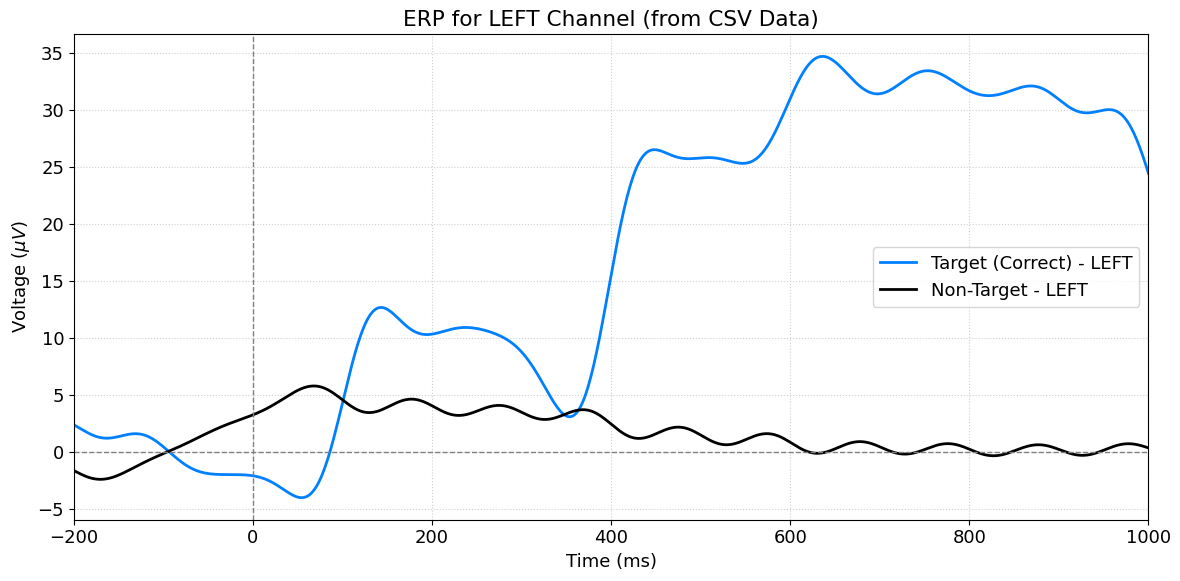

In [10]:
"""
Plot the ERP for LEFT channel
"""
import os

if targetEEG_train is not None and nontargetEEG_train is not None and \
   targetEEG_train.size > 0 and nontargetEEG_train.size > 0:
    
    # Get index for 'LEFT' channel
    try:
        left_channel_idx = eeg_channel_columns.index('LEFT')
    except ValueError as e:
        print(f"Error: Specified EEG channel column not found: {e}. Please check 'eeg_channel_columns'.")
        left_channel_idx = -1 # Indicate not found

    # Plot LEFT channel ERP
    if left_channel_idx != -1:
        erp_target_left = np.mean(targetEEG_train[left_channel_idx, :, :], axis=1)
        erp_nontarget_left = np.mean(nontargetEEG_train[left_channel_idx, :, :], axis=1)
        
        t_erp = np.linspace(frame[0], frame[1], erp_target_left.shape[0])

        plt.rcParams.update({'font.size': 13})
        output_dir = "result"
        os.makedirs(output_dir, exist_ok=True)

        plt.figure(figsize=(12, 6))
        plt.plot(t_erp, erp_target_left, color=[0, 0.5, 1], linewidth=2, label=f'Target (Correct) - {eeg_channel_columns[left_channel_idx]}')
        plt.plot(t_erp, erp_nontarget_left, color=[0, 0, 0], linewidth=2, label=f'Non-Target - {eeg_channel_columns[left_channel_idx]}')

        plt.xlabel('Time (ms)')
        plt.ylabel(r'Voltage ($\mu V$)')
        plt.title(f'ERP for {eeg_channel_columns[left_channel_idx]} Channel (from CSV Data)')
        plt.xlim([-200, 1000]) 
        plt.axhline(0, color='grey', linestyle='--', linewidth=1)
        plt.axvline(0, color='grey', linestyle='--', linewidth=1)
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.legend()
        plt.tight_layout()
        filename = f'ERP_{eeg_channel_columns[left_channel_idx]}_Channel_from_CSV.png'
        save_path = os.path.join(output_dir, filename)
        # plt.savefig(save_path)
        plt.show()
    else:
        print(f"\nSkipping ERP plot for '{eeg_channel_columns[left_channel_idx]}' channel: Not found in 'eeg_channel_columns'.")
else:
    print("\nSkipping ERP plots: No valid target or non-target training epochs available for plotting.")


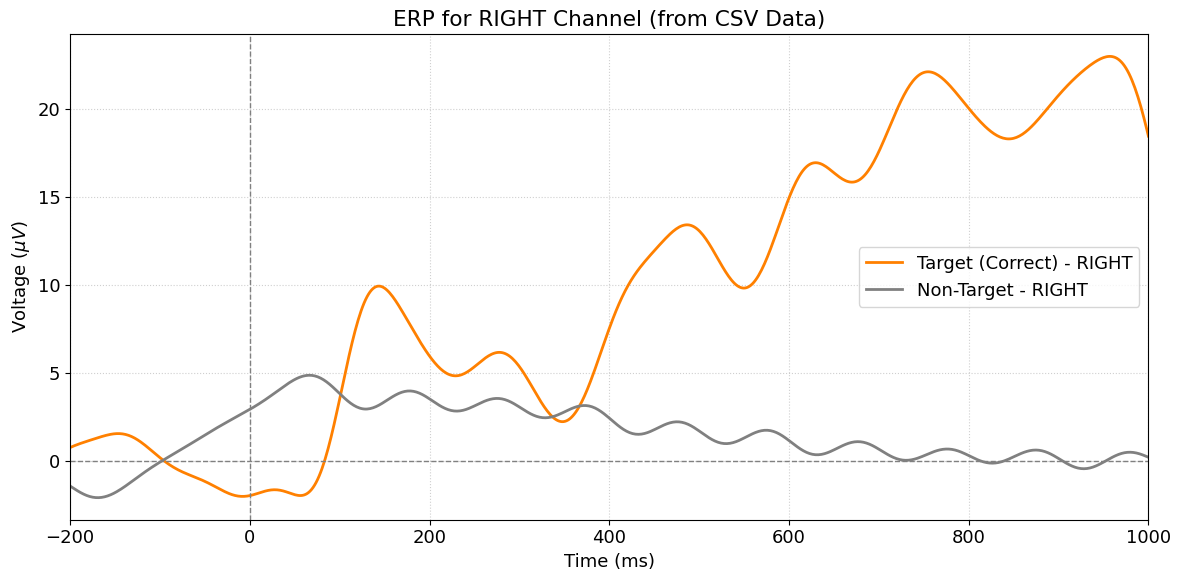

In [11]:
"""
Plot the ERP for RIGHT channel
"""
import os

if targetEEG_train is not None and nontargetEEG_train is not None and \
   targetEEG_train.size > 0 and nontargetEEG_train.size > 0:
    
    # Get index for 'RIGHT' channel
    try:
        right_channel_idx = eeg_channel_columns.index('RIGHT')
    except ValueError as e:
        print(f"Error: Specified EEG channel column not found: {e}. Please check 'eeg_channel_columns'.")
        right_channel_idx = -1 # Indicate not found

    # Plot RIGHT channel ERP
    if right_channel_idx != -1:
        erp_target_right = np.mean(targetEEG_train[right_channel_idx, :, :], axis=1)
        erp_nontarget_right = np.mean(nontargetEEG_train[right_channel_idx, :, :], axis=1)
        
        t_erp = np.linspace(frame[0], frame[1], erp_target_right.shape[0])

        plt.rcParams.update({'font.size': 13})
        output_dir = "result"
        os.makedirs(output_dir, exist_ok=True)

        plt.figure(figsize=(12, 6))
        plt.plot(t_erp, erp_target_right, color=[1, 0.5, 0], linewidth=2, label=f'Target (Correct) - {eeg_channel_columns[right_channel_idx]}')
        plt.plot(t_erp, erp_nontarget_right, color=[0.5, 0.5, 0.5], linewidth=2, label=f'Non-Target - {eeg_channel_columns[right_channel_idx]}')

        plt.xlabel('Time (ms)')
        plt.ylabel(r'Voltage ($\mu V$)')
        plt.title(f'ERP for {eeg_channel_columns[right_channel_idx]} Channel (from CSV Data)')
        plt.xlim([-200, 1000]) 
        plt.axhline(0, color='grey', linestyle='--', linewidth=1)
        plt.axvline(0, color='grey', linestyle='--', linewidth=1)
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.legend()
        plt.tight_layout()
        filename = f'ERP_{eeg_channel_columns[right_channel_idx]}_Channel_from_CSV.png'
        save_path = os.path.join(output_dir, filename)
        # plt.savefig(save_path)
        plt.show()
    else:
        print(f"\nSkipping ERP plot for '{eeg_channel_columns[right_channel_idx]}' channel: Not found in 'eeg_channel_columns'.")

else:
    print("\nSkipping ERP plots: No valid target or non-target training epochs available for plotting.")


In [12]:
def decimation_by_avg(data, factor):
    """
    Function for replacing each sequence of previous factor samples with their average.
    Downsamples 3D data [ch, time, trial] by averaging.
    """
    # data.shape = [ch, time, trial]
    ratio_dsample = factor
    n_ch, n_frame, n_trial = data.shape

    # Calculate the number of decimated frames
    decimated_frame = int(np.floor(n_frame / ratio_dsample))

    # Memory pre-allocation for decimated data
    decimated_data = np.zeros((n_ch, decimated_frame, n_trial))

    for i in range(n_trial):
        for j in range(decimated_frame):
            # Extract current epoch data for all channels
            cur_data_epoch = data[:, :, i]
            # Calculate mean across the time window for each channel
            decimated_data[:, j, i] = np.mean(cur_data_epoch[:, j * ratio_dsample : (j + 1) * ratio_dsample], axis=1)

    return decimated_data

# Ensure targetEEG_train and nontargetEEG_train are not None and have data
if targetEEG_train is not None and targetEEG_train.size > 0 and \
   nontargetEEG_train is not None and nontargetEEG_train.size > 0:

    # Downsample the epoched EEG data
    # Factor 24: 720 samples / 24 = 30 samples (features per channel)
    down_target = decimation_by_avg(targetEEG_train, 24)
    down_nontarget = decimation_by_avg(nontargetEEG_train, 24)

    # Reshape the 3D data [channels, decimated_time, trials] to 2D [trials, features]
    # Features will be (channels * decimated_time)
    ch_target, frame_target, trial_target = down_target.shape
    ch_nontarget, frame_nontarget, trial_nontarget = down_nontarget.shape # Corrected variable name

    feat_target = np.reshape(down_target, (ch_target * frame_target, trial_target))
    feat_nontarget = np.reshape(down_nontarget, (ch_nontarget * frame_nontarget, trial_nontarget))

    # Transpose features to be [n_samples, n_features] as expected by scikit-learn
    feat_target = feat_target.transpose() 
    feat_nontarget = feat_nontarget.transpose()

    # Create labels: 1 for target and -1 for non-target
    y_target = np.ones((feat_target.shape[0], 1))
    y_nontarget = -np.ones((feat_nontarget.shape[0], 1))

    # Stack features and labels for training
    feat_train = np.vstack((feat_target, feat_nontarget))
    y_train = np.vstack((y_target, y_nontarget))

    # Shuffle the training data to randomize order for fair training
    idx_train = np.arange(feat_train.shape[0])
    np.random.shuffle(idx_train)

    feat_train = feat_train[idx_train, :]
    y_train = y_train[idx_train, :]

    print(f"\nShape of downsampled and reshaped target features: {feat_target.shape}")
    print(f"Shape of downsampled and reshaped non-target features: {feat_nontarget.shape}")
    print(f"Shape of combined training features: {feat_train.shape}")
    print(f"Shape of combined training labels: {y_train.shape}")
else:
    print("\nSkipping classifier preprocessing: No valid target or non-target training epochs available.")
    feat_train = None
    y_train = None



Shape of downsampled and reshaped target features: (80, 90)
Shape of downsampled and reshaped non-target features: (1686, 90)
Shape of combined training features: (1766, 90)
Shape of combined training labels: (1766, 1)


In [13]:
def get_stats(dat, x_columns, y):
    """
    Performs Ordinary Least Squares (OLS) regression and returns the results.
    Adds a constant to the independent variables as required by statsmodels for intercept.
    """
    x = dat[:, x_columns]
    x = sm.add_constant(x) # Add a constant for the intercept
    results = sm.OLS(y, x).fit() # OLS: ordinary least-square
    return results

# Proceed with feature selection only if training data is available
if feat_train is not None and y_train is not None and feat_train.shape[1] > 0:
    # Initialize x_column with all feature indices
    x_column = np.arange(feat_train.shape[1])
    
    initial_feature_count = len(x_column)
    print(f"\nStarting feature selection with {initial_feature_count} features.")

    # Modified: Skip backward elimination and direct selection of top 60 features.
    # Use all available features after decimation.
    feat_train_select = feat_train # Use all features
    x_column_final_selection = x_column # Keep track of original indices if needed later

    print(f"\nSkipping backward elimination and selection of top 60 features as requested.")
    print(f"Using all {feat_train_select.shape[1]} features for training.")
    print(f"Shape of training features after 'selection' (all features): {feat_train_select.shape}")
    
else:
    print("\nSkipping feature selection: Training data (feat_train, y_train) is not properly initialized or empty.")
    feat_train_select = np.array([]) # No features selected
    x_column_final_selection = np.array([]) # Ensure this is also empty if no features



Starting feature selection with 90 features.

Skipping backward elimination and selection of top 60 features as requested.
Using all 90 features for training.
Shape of training features after 'selection' (all features): (1766, 90)


In [14]:
# Linear regression
if feat_train_select.size > 0 and y_train is not None:
    linear_model = LinearRegression()
    linear_model.fit(feat_train_select, y_train)

    # Predict on training data
    pred_train = np.sign(linear_model.predict(feat_train_select))
    
    # Calculate and print training accuracy
    accuracy_train = np.sum(pred_train == y_train) / len(pred_train)
    print(f'\nClassification accuracy on training data: {accuracy_train:.4f}')
else:
    print("\nSkipping classifier training: No selected features or training labels available.")
    linear_model = None # Ensure model is None if not trained



Classification accuracy on training data: 0.9553


In [ ]:
model_filename = 'Experiment/data/models/p300_classifier_model.pkl'
feature_selection_filename = 'Experiment/data/models/p300_feature_selection_indices.pkl'

if linear_model is not None:
    try:
        joblib.dump(linear_model, model_filename)
        print(f"\n✅ Trained classifier model saved to {model_filename}")

        if 'x_column_final_selection' in locals() and x_column_final_selection is not None and x_column_final_selection.size > 0:
            joblib.dump(x_column_final_selection, feature_selection_filename)
            print(f"✅ Feature selection indices saved to {feature_selection_filename}")
        else:
            print("⚠️ Warning: x_column_final_selection not found, is None, or empty. This might mean no explicit feature selection was performed, or it was not captured. Ensure your prediction logic handles this if these indices are needed.")

    except Exception as e:
        print(f"❌ Error saving model or feature selection: {e}")
else:
    print("\n⚠️ No trained model (linear_model) found to save.")

targetEEG_test_combined = None
nontargetEEG_test_combined = None

if EEG_csv['test']:
    for n_test in range(len(EEG_csv['test'])):
        print(f"\nProcessing test session {n_test + 1} for classification...")
        data_test = np.asarray(EEG_csv['test'][n_test]['data'])
        srate_test = EEG_csv['test'][n_test]['srate']
        markers_test = np.asarray(EEG_csv['test'][n_test]['markers_target'])

        if data_test.size == 0:
            print(f"Skipping test session {n_test+1}: No EEG data found.")
            continue

        data_filtered_test = butter_bandpass_filter(data_test, 0.5, 10, srate_test, 4)

        targetID_test = np.where(markers_test == 1)[0]
        nontargetID_test = np.where(markers_test == 2)[0]

        print(f"Test Session {n_test+1}: Found {len(targetID_test)} target events and {len(nontargetID_test)} non-target events.")

        tmp_targetEEG_test = extractEpoch3D(data_filtered_test, targetID_test, srate_test, baseline, frame, False)
        tmp_nontargetEEG_test = extractEpoch3D(data_filtered_test, nontargetID_test, srate_test, baseline, frame, False)

        if tmp_targetEEG_test.size == 0 and len(targetID_test) > 0:
            print(f"Warning: No valid target epochs extracted for test session {n_test + 1} despite {len(targetID_test)} markers.")
        if tmp_nontargetEEG_test.size == 0 and len(nontargetID_test) > 0:
            print(f"Warning: No valid non-target epochs extracted for test session {n_test + 1} despite {len(nontargetID_test)} markers.")

        if tmp_targetEEG_test.size == 0 and tmp_nontargetEEG_test.size == 0:
            print(f"Warning: No valid target or non-target epochs extracted for test session {n_test + 1}. Skipping stacking.")
            continue

        if targetEEG_test_combined is None:
            targetEEG_test_combined = tmp_targetEEG_test
            nontargetEEG_test_combined = tmp_nontargetEEG_test
        else:
            if tmp_targetEEG_test.size > 0:
                targetEEG_test_combined = np.dstack((targetEEG_test_combined, tmp_targetEEG_test))
            if tmp_nontargetEEG_test.size > 0:
                nontargetEEG_test_combined = np.dstack((nontargetEEG_test_combined, tmp_nontargetEEG_test))
else:
    print("\nNo test data loaded from CSV. Skipping test data evaluation.")

if linear_model is None:
    try:
        linear_model = joblib.load(model_filename)
        print(f"\n✅ Classifier model loaded from {model_filename}")
    except FileNotFoundError:
        print(f"❌ Error: Model file '{model_filename}' not found. Please ensure it has been saved.")
        linear_model = None
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        linear_model = None

if 'x_column_final_selection' not in locals() or x_column_final_selection is None or x_column_final_selection.size == 0:
    try:
        with open(feature_selection_filename, 'rb') as f:
            if f.read(1):
                x_column_final_selection = joblib.load(feature_selection_filename)
                print(f"✅ Feature selection indices loaded from {feature_selection_filename}")
            else:
                print(f"⚠️ Warning: Feature selection file '{feature_selection_filename}' is empty. Proceeding without specific feature selection indices.")
                x_column_final_selection = np.arange(feat_test.shape[1])
    except FileNotFoundError:
        print(f"❌ Error: Feature selection file '{feature_selection_filename}' not found. Assuming all features for prediction if needed.")
        x_column_final_selection = np.array([])
    except Exception as e:
        print(f"❌ Error loading feature selection: {e}")
        x_column_final_selection = np.array([])

if targetEEG_test_combined is not None and targetEEG_test_combined.size > 0 and \
   nontargetEEG_test_combined is not None and nontargetEEG_test_combined.size > 0 and \
   linear_model is not None:
                               # feat_train_select.size > 0 is not relevant for test data processing,
                               # as feat_train_select is from training.

    down_target_test = decimation_by_avg(targetEEG_test_combined, 24)
    down_nontarget_test = decimation_by_avg(nontargetEEG_test_combined, 24)

    ch_target_test, frame_target_test, trial_target_test = down_target_test.shape
    ch_nontarget_test, frame_nontarget_test, trial_nontarget_test = down_nontarget_test.shape

    feat_target_test = np.reshape(down_target_test, (ch_target_test * frame_target_test, trial_target_test)).transpose()
    feat_nontarget_test = np.reshape(down_nontarget_test, (ch_nontarget_test * frame_nontarget_test, trial_nontarget_test)).transpose()

    y_target_test = np.ones((feat_target_test.shape[0], 1))
    y_nontarget_test = -np.ones((feat_nontarget_test.shape[0], 1))

    feat_test = np.vstack((feat_target_test, feat_nontarget_test))
    y_test = np.vstack((y_target_test, y_nontarget_test))

    if x_column_final_selection is not None and x_column_final_selection.size > 0:
        feat_test_select = feat_test[:, x_column_final_selection]
        print(f"\nShape of test features after applying 'selection': {feat_test_select.shape}")

        pred_test = np.sign(linear_model.predict(feat_test_select))

        accuracy_test = np.sum(pred_test == y_test) / len(pred_test)
        print(f'Classification accuracy on test data: {accuracy_test:.4f}')
    else:
        print("\nSkipping test data prediction: Feature selection indices are missing or empty. Cannot apply selection.")
else:
    print("\nSkipping test data evaluation: No valid test epochs available or classifier not trained/loaded.")


Processing test session 1 for classification...
Test Session 1: Found 30 target events and 570 non-target events.
Note: 9 events were skipped due to out-of-bounds issues during epoch or baseline extraction.

Shape of test features after applying 'selection' (all features): (591, 90)
Classification accuracy on test data: 0.9492
